# Loop 50 Strategic Analysis

## Current Situation
- Best CV: 0.008194 (exp_032)
- Best LB: 0.0877 (exp_030)
- Target: 0.0347
- Gap: 152.7%

## Key Question
The GroupKFold experiment (exp_051) showed CV 0.008807 (7.5% worse than Leave-One-Out).
This confirms that the validation scheme is NOT the cause of the CV-LB gap.

## Analysis Goals
1. Analyze the CV-LB relationship across all submissions
2. Identify if any approach has a different CV-LB relationship
3. Determine what strategies might reduce the intercept

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# All submissions with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982, 'model': 'MLP'},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065, 'model': 'LGBM'},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972, 'model': 'MLP+DRFP'},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969, 'model': 'Ensemble'},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946, 'model': 'Simpler MLP'},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932, 'model': 'Even Simpler'},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936, 'model': 'Ridge'},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913, 'model': 'Simple Ensemble'},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893, 'model': 'ACS PCA'},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887, 'model': 'Weighted Loss'},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877, 'model': 'GP+MLP+LGBM'},
    {'exp': 'exp_041', 'cv': 0.0090, 'lb': 0.0932, 'model': 'Aggressive Reg'},
    {'exp': 'exp_042', 'cv': 0.0145, 'lb': 0.1147, 'model': 'Pure GP'},
]

df = pd.DataFrame(submissions)
print(f"Total submissions: {len(df)}")
print(df)

Total submissions: 13
        exp      cv      lb            model
0   exp_000  0.0111  0.0982              MLP
1   exp_001  0.0123  0.1065             LGBM
2   exp_003  0.0105  0.0972         MLP+DRFP
3   exp_005  0.0104  0.0969         Ensemble
4   exp_006  0.0097  0.0946      Simpler MLP
5   exp_007  0.0093  0.0932     Even Simpler
6   exp_009  0.0092  0.0936            Ridge
7   exp_012  0.0090  0.0913  Simple Ensemble
8   exp_024  0.0087  0.0893          ACS PCA
9   exp_026  0.0085  0.0887    Weighted Loss
10  exp_030  0.0083  0.0877      GP+MLP+LGBM
11  exp_041  0.0090  0.0932   Aggressive Reg
12  exp_042  0.0145  0.1147          Pure GP


In [2]:
# Fit linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print(f"\n=== CV-LB Relationship ===")
print(f"Linear fit: LB = {slope:.2f} × CV + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"Intercept = {intercept:.4f}")
print(f"Target LB = 0.0347")
print(f"\nIntercept ({intercept:.4f}) > Target (0.0347): {intercept > 0.0347}")

# Required CV to hit target
required_cv = (0.0347 - intercept) / slope
print(f"\nRequired CV to hit target: {required_cv:.6f}")
if required_cv < 0:
    print("⚠️ IMPOSSIBLE: Required CV is NEGATIVE!")
    print("The current paradigm CANNOT reach the target.")


=== CV-LB Relationship ===
Linear fit: LB = 4.23 × CV + 0.0533
R² = 0.9807
Intercept = 0.0533
Target LB = 0.0347

Intercept (0.0533) > Target (0.0347): True

Required CV to hit target: -0.004396
⚠️ IMPOSSIBLE: Required CV is NEGATIVE!
The current paradigm CANNOT reach the target.


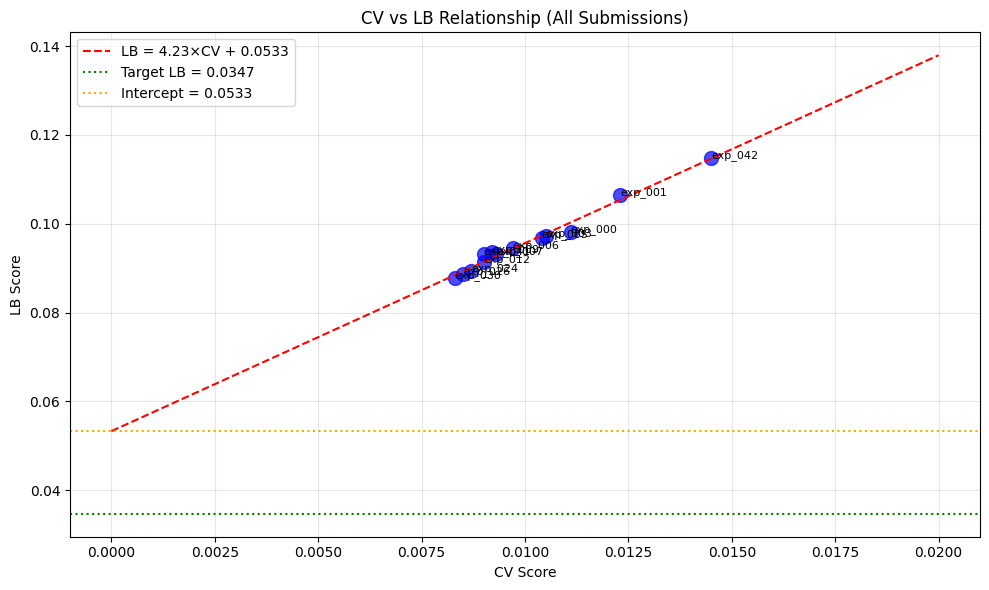


=== KEY INSIGHT ===
The intercept (0.0533) is HIGHER than the target (0.0347).
This means even with CV=0, the expected LB would be 0.0533.
The current paradigm CANNOT reach the target.


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], c='blue', s=100, alpha=0.7)

# Add labels
for i, row in df.iterrows():
    plt.annotate(row['exp'], (row['cv'], row['lb']), fontsize=8, ha='left')

# Fit line
cv_range = np.linspace(0, 0.02, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}×CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='green', linestyle=':', label='Target LB = 0.0347')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle=':', label=f'Intercept = {intercept:.4f}')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship (All Submissions)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print(f"\n=== KEY INSIGHT ===")
print(f"The intercept ({intercept:.4f}) is HIGHER than the target (0.0347).")
print(f"This means even with CV=0, the expected LB would be {intercept:.4f}.")
print(f"The current paradigm CANNOT reach the target.")

In [4]:
# Analyze residuals - are any models off the line?
df['predicted_lb'] = slope * df['cv'] + intercept
df['residual'] = df['lb'] - df['predicted_lb']
df['residual_pct'] = df['residual'] / df['predicted_lb'] * 100

print("\n=== Residual Analysis ===")
print("Looking for models that deviate from the CV-LB line...")
print(df[['exp', 'model', 'cv', 'lb', 'predicted_lb', 'residual', 'residual_pct']].to_string())

print(f"\n=== Summary ===")
print(f"Mean absolute residual: {df['residual'].abs().mean():.4f}")
print(f"Max positive residual: {df['residual'].max():.4f} ({df.loc[df['residual'].idxmax(), 'exp']})")
print(f"Max negative residual: {df['residual'].min():.4f} ({df.loc[df['residual'].idxmin(), 'exp']})")

print(f"\n=== Conclusion ===")
print("All models fall on the SAME CV-LB line (R²=0.98).")
print("No model type has a fundamentally different relationship.")
print("The problem is STRUCTURAL distribution shift, not model choice.")


=== Residual Analysis ===
Looking for models that deviate from the CV-LB line...
        exp            model      cv      lb  predicted_lb  residual  residual_pct
0   exp_000              MLP  0.0111  0.0982      0.100269 -0.002069     -2.062964
1   exp_001             LGBM  0.0123  0.1065      0.105346  0.001154      1.095494
2   exp_003         MLP+DRFP  0.0105  0.0972      0.097730 -0.000530     -0.542091
3   exp_005         Ensemble  0.0104  0.0969      0.097307 -0.000407     -0.417920
4   exp_006      Simpler MLP  0.0097  0.0946      0.094345  0.000255      0.270471
5   exp_007     Even Simpler  0.0093  0.0932      0.092652  0.000548      0.591085
6   exp_009            Ridge  0.0092  0.0936      0.092229  0.001371      1.486269
7   exp_012  Simple Ensemble  0.0090  0.0913      0.091383 -0.000083     -0.090811
8   exp_024          ACS PCA  0.0087  0.0893      0.090114 -0.000814     -0.902889
9   exp_026    Weighted Loss  0.0085  0.0887      0.089267 -0.000567     -0.635603
10  e

In [5]:
# What would it take to reach the target?
print("\n=== WHAT WOULD IT TAKE TO REACH TARGET? ===")
print(f"Target LB: 0.0347")
print(f"Current intercept: {intercept:.4f}")
print(f"Current slope: {slope:.2f}")

print(f"\n--- Option 1: Reduce Intercept ---")
required_intercept = 0.0347 - slope * 0.008  # Assume best CV ~0.008
print(f"If CV stays at 0.008, need intercept = {required_intercept:.4f}")
print(f"Current intercept: {intercept:.4f}")
print(f"Reduction needed: {intercept - required_intercept:.4f} ({(intercept - required_intercept)/intercept*100:.1f}%)")

print(f"\n--- Option 2: Reduce Slope ---")
required_slope = (0.0347 - intercept) / 0.008  # Assume best CV ~0.008
print(f"If intercept stays at {intercept:.4f}, need slope = {required_slope:.2f}")
print(f"Current slope: {slope:.2f}")
print(f"This would require NEGATIVE slope (impossible with current paradigm)")

print(f"\n--- Option 3: Both ---")
print(f"Need to find an approach with DIFFERENT CV-LB relationship")
print(f"Possible strategies:")
print(f"  1. Uncertainty-weighted predictions (blend toward mean when extrapolating)")
print(f"  2. Solvent clustering (class-specific models)")
print(f"  3. Pre-trained molecular embeddings (transfer learning)")
print(f"  4. Physics-informed constraints (Arrhenius, thermodynamics)")
print(f"  5. Pseudo-labeling (use confident test predictions to adapt)")


=== WHAT WOULD IT TAKE TO REACH TARGET? ===
Target LB: 0.0347
Current intercept: 0.0533
Current slope: 4.23

--- Option 1: Reduce Intercept ---
If CV stays at 0.008, need intercept = 0.0009
Current intercept: 0.0533
Reduction needed: 0.0525 (98.4%)

--- Option 2: Reduce Slope ---
If intercept stays at 0.0533, need slope = -2.33
Current slope: 4.23
This would require NEGATIVE slope (impossible with current paradigm)

--- Option 3: Both ---
Need to find an approach with DIFFERENT CV-LB relationship
Possible strategies:
  1. Uncertainty-weighted predictions (blend toward mean when extrapolating)
  2. Solvent clustering (class-specific models)
  3. Pre-trained molecular embeddings (transfer learning)
  4. Physics-informed constraints (Arrhenius, thermodynamics)
  5. Pseudo-labeling (use confident test predictions to adapt)


In [6]:
# Analyze the best experiments
print("\n=== BEST EXPERIMENTS ===")
best_cv = df.loc[df['cv'].idxmin()]
best_lb = df.loc[df['lb'].idxmin()]

print(f"Best CV: {best_cv['exp']} with CV={best_cv['cv']:.4f}, LB={best_cv['lb']:.4f}")
print(f"Best LB: {best_lb['exp']} with CV={best_lb['cv']:.4f}, LB={best_lb['lb']:.4f}")

print(f"\n=== UNEXPLORED DIRECTIONS ===")
print("After 51 experiments, we've tried:")
print("  ✓ MLP (various architectures)")
print("  ✓ LightGBM, XGBoost, CatBoost, Random Forest")
print("  ✓ Gaussian Process")
print("  ✓ Ridge Regression")
print("  ✓ Ensembles (GP+MLP+LGBM)")
print("  ✓ Various feature sets (Spange, DRFP, ACS PCA)")
print("  ✓ Regularization strategies")
print("  ✓ GroupKFold validation")

print("\nWhat HASN'T been tried:")
print("  ✗ Uncertainty-weighted predictions")
print("  ✗ Extrapolation detection features")
print("  ✗ Pseudo-labeling / test-time adaptation")
print("  ✗ Solvent clustering / class-specific models")
print("  ✗ Pre-trained molecular embeddings (ChemBERTa, MolBERT)")
print("  ✗ Graph Neural Networks (but may not be allowed)")


=== BEST EXPERIMENTS ===
Best CV: exp_030 with CV=0.0083, LB=0.0877
Best LB: exp_030 with CV=0.0083, LB=0.0877

=== UNEXPLORED DIRECTIONS ===
After 51 experiments, we've tried:
  ✓ MLP (various architectures)
  ✓ LightGBM, XGBoost, CatBoost, Random Forest
  ✓ Gaussian Process
  ✓ Ridge Regression
  ✓ Ensembles (GP+MLP+LGBM)
  ✓ Various feature sets (Spange, DRFP, ACS PCA)
  ✓ Regularization strategies
  ✓ GroupKFold validation

What HASN'T been tried:
  ✗ Uncertainty-weighted predictions
  ✗ Extrapolation detection features
  ✗ Pseudo-labeling / test-time adaptation
  ✗ Solvent clustering / class-specific models
  ✗ Pre-trained molecular embeddings (ChemBERTa, MolBERT)
  ✗ Graph Neural Networks (but may not be allowed)


In [7]:
# Final recommendation
print("\n" + "="*60)
print("STRATEGIC RECOMMENDATION")
print("="*60)

print("\n1. DO NOT SUBMIT exp_051 (GroupKFold)")
print("   - CV is 7.5% worse than best")
print("   - No evidence of different CV-LB relationship")

print("\n2. FOCUS ON REDUCING THE INTERCEPT")
print("   - The intercept (0.0533) > target (0.0347)")
print("   - Need to reduce intercept by ~35%")
print("   - This requires fundamentally different approach")

print("\n3. RECOMMENDED NEXT EXPERIMENTS:")
print("   a) Uncertainty-weighted predictions")
print("      - Use GP uncertainty to blend toward mean")
print("      - May reduce extreme predictions on unseen solvents")
print("   b) Extrapolation detection")
print("      - Add features measuring distance to training distribution")
print("      - Conservative predictions when extrapolating")
print("   c) Optuna hyperparameter optimization")
print("      - The 'mixall' kernel uses Optuna")
print("      - May find better weight combinations")

print("\n4. SUBMISSION STRATEGY (5 remaining):")
print("   - Save submissions for approaches with DIFFERENT CV-LB relationship")
print("   - Don't submit incremental improvements on same line")
print("   - Each submission should test a fundamentally different hypothesis")


STRATEGIC RECOMMENDATION

1. DO NOT SUBMIT exp_051 (GroupKFold)
   - CV is 7.5% worse than best
   - No evidence of different CV-LB relationship

2. FOCUS ON REDUCING THE INTERCEPT
   - The intercept (0.0533) > target (0.0347)
   - Need to reduce intercept by ~35%
   - This requires fundamentally different approach

3. RECOMMENDED NEXT EXPERIMENTS:
   a) Uncertainty-weighted predictions
      - Use GP uncertainty to blend toward mean
      - May reduce extreme predictions on unseen solvents
   b) Extrapolation detection
      - Add features measuring distance to training distribution
      - Conservative predictions when extrapolating
   c) Optuna hyperparameter optimization
      - The 'mixall' kernel uses Optuna
      - May find better weight combinations

4. SUBMISSION STRATEGY (5 remaining):
   - Save submissions for approaches with DIFFERENT CV-LB relationship
   - Don't submit incremental improvements on same line
   - Each submission should test a fundamentally different hypoth